In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
#set_contents
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Data_set",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3171 files belonging to 4 classes.


In [ ]:
#directory names
class_names = dataset.class_names
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy']

In [ ]:
#converting into numpy
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 0 0 1 1 0 3 3 0 3 3 3 3 1 2 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0]


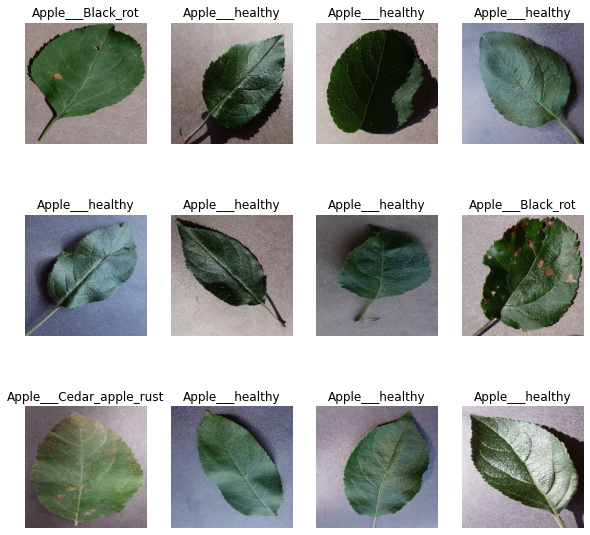

In [ ]:
#visualization
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)


100

In [ ]:
#training data size
train_size = 0.8
len(dataset)*train_size


80.0

In [ ]:
#training data
train_ds = dataset.take(80)
len(train_ds)

80

In [ ]:
#test data
test_ds = dataset.skip(80)
len(test_ds)


20

In [ ]:
#validation data size
val_size=0.1
len(dataset)*val_size


10.0

In [ ]:
#validation data 
val_ds = test_ds.take(10)
len(val_ds)


10

In [ ]:
#actual test data
test_ds = test_ds.skip(10)
len(test_ds)


10

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [ ]:
len(train_ds)


80

In [ ]:
len(val_ds)

10

In [ ]:
len(test_ds)


10

In [ ]:
#cache and shuffel
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
#Resizing
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])


In [ ]:
#data augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


In [ ]:
#Applying data augmentation
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
#model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

In [ ]:
#compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
#train the model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)


Epoch 1/50
80/80 [==============================] - 98s 1s/step - loss: 1.1603 - accuracy: 0.5200 - val_loss: 0.8792 - val_accuracy: 0.5842
Epoch 2/50
80/80 [==============================] - 76s 942ms/step - loss: 0.7870 - accuracy: 0.6594 - val_loss: 0.6829 - val_accuracy: 0.7216
Epoch 3/50
80/80 [==============================] - 73s 911ms/step - loss: 0.7257 - accuracy: 0.6800 - val_loss: 0.6638 - val_accuracy: 0.7629
Epoch 4/50
80/80 [==============================] - 71s 884ms/step - loss: 0.6447 - accuracy: 0.7353 - val_loss: 0.5278 - val_accuracy: 0.7904
Epoch 5/50
80/80 [==============================] - 73s 907ms/step - loss: 0.5386 - accuracy: 0.7803 - val_loss: 0.7119 - val_accuracy: 0.7629
Epoch 6/50
80/80 [==============================] - 74s 918ms/step - loss: 0.4293 - accuracy: 0.8305 - val_loss: 0.4291 - val_accuracy: 0.8316
Epoch 7/50
80/80 [==============================] - 72s 905ms/step - loss: 0.3753 - accuracy: 0.8522 - val_loss: 0.3722 - val_accuracy: 0.8694
Ep

In [ ]:
#evalute our model on test data
scores = model.evaluate(test_ds)

10/10 [==============================] - 12s 261ms/step - loss: 0.0521 - accuracy: 0.9781


In [ ]:
#visualizing score parameter
scores

[0.05213494971394539, 0.9781249761581421]

In [ ]:
#checking our model params/ we also get key of history
history.params

{'verbose': 1, 'epochs': 50, 'steps': 80}

In [ ]:
#we can get each key like if you want only loss so
history.history["loss"]

[1.1603349447250366,
 0.7869693636894226,
 0.7257165312767029,
 0.6447474956512451,
 0.5385704040527344,
 0.42928656935691833,
 0.37531033158302307,
 0.3874954283237457,
 0.3460024297237396,
 0.34811919927597046,
 0.3345685601234436,
 0.29080843925476074,
 0.22854113578796387,
 0.22998201847076416,
 0.18353219330310822,
 0.1679369956254959,
 0.1344529539346695,
 0.132828488945961,
 0.14471271634101868,
 0.09821075946092606,
 0.1460140496492386,
 0.08171430975198746,
 0.046379078179597855,
 0.11785760521888733,
 0.03962501138448715,
 0.09754973649978638,
 0.07003064453601837,
 0.028608117252588272,
 0.024267053231596947,
 0.025778504088521004,
 0.03735458105802536,
 0.025372572243213654,
 0.029954103752970695,
 0.08884935826063156,
 0.03412202373147011,
 0.021453501656651497,
 0.021715808659791946,
 0.046244483441114426,
 0.022673334926366806,
 0.025924643501639366,
 0.009729940444231033,
 0.021542351692914963,
 0.03128023073077202,
 0.034955281764268875,
 0.022075925022363663,
 0.04031

In [ ]:
#aslo check the length
len(history.history["accuracy"])

50

In [ ]:
#we store our all keys in variables to plot the data 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

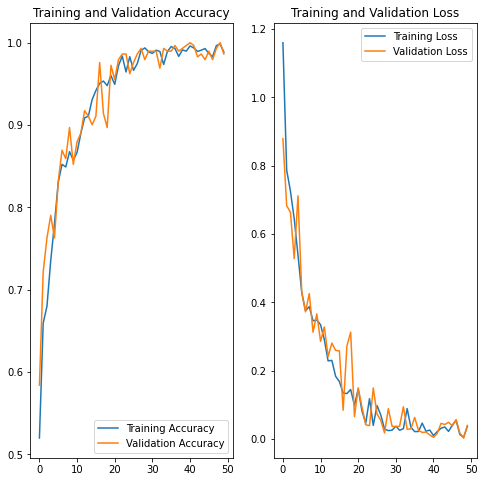

In [ ]:
#Validation accuracy 
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#loss validation
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Apple___healthy
predicted label: Apple___healthy


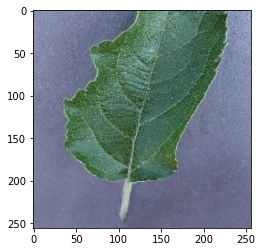

In [ ]:
#start predicting with first batch
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
#function to predict the accuracy and confidence
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

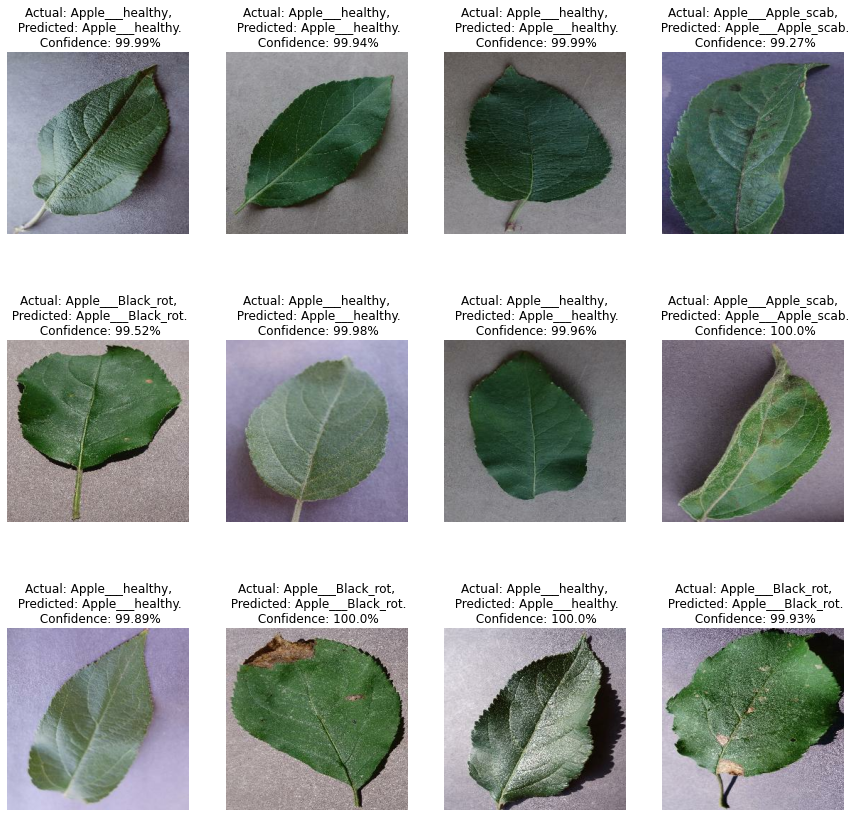

In [ ]:
#plot the result
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


In [ ]:
#auto increment of our model versions
#import os
#model_version=max([int(i) for i in os.listdir("Our_models") + [0]])+1
#model.save(f"Our_models/{model_version}")